In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from vit_keras.vit import vit_l32  # keep this line for VIT model!

2023-06-13 14:04:34.176731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
FOOD_PATH = "food/"
FOOD_DIR = glob.glob("food/*")
CATEGORIES_PATH = "categories.csv"

MODELS = ["sg-food-233-xception", "sg-food-233-densenet121", "sg-food-233-densenet201",
          "sg-food-233-resnet152v2", "sg-food-233-inceptionv3", "sg-food-233-inceptionresnetv2"]
CHECKPOINT_PATHS = ["checkpoints/" + MODEL + ".h5" for MODEL in MODELS]
MODEL_PATHS = ["models/" + MODEL + ".h5" for MODEL in MODELS]

IMAGE_SIZE = 512
TOP_N = 5

In [3]:
categories = list(pd.read_csv(CATEGORIES_PATH, header=None)[0])

In [4]:
def acc_top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [5]:
def load_models():
    loaded_models = []
    for CHECKPOINT_PATH in CHECKPOINT_PATHS:
        loaded_models.append(load_model(CHECKPOINT_PATH, custom_objects={"acc_top5": acc_top5}))
    print("Models Loaded")
    return loaded_models

In [6]:
models = load_models()

Models Loaded


In [7]:
def predict(model, filepath, top_n=None):
    test_image = load_img(filepath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    test_image_array = img_to_array(test_image)
    test_image_array = np.expand_dims(test_image_array, axis=0)
    test_image_array = test_image_array / 255.
    prediction = model.predict(test_image_array, verbose=0)
    if top_n:
        predicted_label = np.argsort(prediction[0])[::-1][:top_n]
    else:
        predicted_label = np.argsort(prediction[0])[::-1]
    predicted_score = prediction[0][predicted_label]
    return predicted_label, predicted_score

In [8]:
def ensemble_predict(filepath, top_n=None):
    predictions = {}
    for model in models:
        predicted_labels, predicted_scores = predict(model, filepath)
        for i, label in enumerate(predicted_labels):
            if categories[predicted_labels[i]] in predictions:
                if predictions[categories[predicted_labels[i]]] < predicted_scores[i]:
                    predictions[categories[predicted_labels[i]]] = predicted_scores[i]
            else:
                predictions[categories[predicted_labels[i]]] = predicted_scores[i]
    if top_n:
        predictions = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True)[:top_n])
    else:
        predictions = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))
    return predictions

food/chicken rice.jpg
chicken rice
{'chicken rice': 0.9999939, 'char siew': 0.02026512, 'Duck Rice': 0.008804538, 'yam rice': 0.007237858, 'nasi lemak': 0.0046091164}
food/test5.jpg
milk
{'milk': 0.98270696, 'Chocolate': 0.73347723, 'Alcoholic Beverage': 0.2014189, 'orange': 0.12329376, 'Sweets': 0.10961995}
food/test4.png
chicken rice
{'chicken rice': 0.98415715, 'char siew': 0.3053578, 'Indian Pancake': 0.13340886, 'bakso': 0.09239432, 'Rice, chicken katsu with Japanese curry': 0.08087273}
food/test1.png
satay
{'satay': 0.9997595, 'bak kwa': 0.04547465, 'fried prawn': 0.026967699, 'kebab - chicken': 0.022963798, 'goreng pisang': 0.016119419}
food/test3.png
Tauhu Goreng
{'Tauhu Goreng': 0.7368931, 'Kway Teow': 0.25145474, 'Lor mee': 0.23080865, 'rojak': 0.16377556, 'chai tow kuay': 0.15327893}
food/test2.png
hokkien prawn mee
{'hokkien prawn mee': 0.69956493, 'Udon': 0.67001307, 'bak chor mee': 0.54542357, 'pasta - fettuccine': 0.20090006, 'Laksa': 0.11726793}
food/xiao long bao.jpg
x

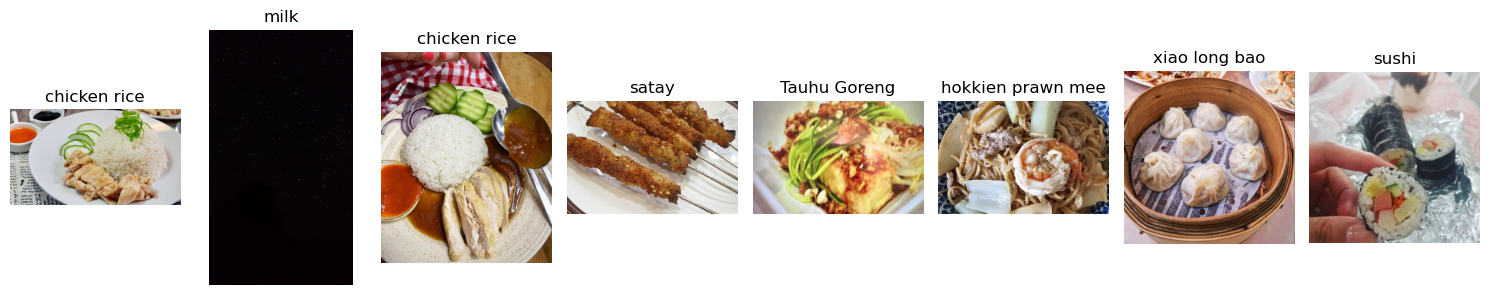

In [9]:
plt.figure(figsize=(15, 3))

for idx, food in enumerate(FOOD_DIR):
    pred = ensemble_predict(food, TOP_N)
    plt.subplot(1, len(FOOD_DIR), idx + 1)
    print(food)
    img = plt.imread(food)
    plt.title(list(pred.keys())[0])
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    print("=" * 50)
    print(list(pred.keys())[0])
    print(pred)
    print("=" * 50)
plt.tight_layout()